# Week 8 Day 3: Fitting tools

## Objectives:
* Look again at fitting tools
* Set up a project in git (review of git, project structure)

### Note about crash last time!

GooFit and LmFit both seem to have compiled code that expects OpenMP - and at least on my Mac, they were linked with different OpenMP libraries (Anaconda's Intel libomp for LmFit, and HomeBrew's libomp for GooFit). So that's why it crashed. I've reinstalled GooFit without OpenMP for now.

### GooFit

If you really want to try GooFit, you can try this on OSC:
    
```
!pip install --user scikit-build cmake
!PATH=$HOME/.local/bin:$PATH pip install --user --verbose goofit
```

The extra requirements here are partially to ensure it gets the highest level of optimization, and partially requirements that will eventually go away.

If you are on macOS, scikit-build is broken, you'll need `!pip install scikit-build==0.6.1`.

In [1]:
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

#### Prepare data

We'll be making a set of data out of a Gaussian + linear.

In [2]:
state = np.random.RandomState(42)
gauss_part = state.normal(1,2,size=100_000)
lin_part = state.uniform(low=-10,high=10,size=50_000)
total_rand = np.concatenate([gauss_part, lin_part])

In [3]:
import goofit

We need an observable, with a range from -10 to 10.

In [4]:
x = goofit.Observable('x', -10, 10)

We can make an unbinned (or binned) dataset; we need to list the variables it will contain.

In [5]:
data = goofit.UnbinnedDataSet(x)

Let's read in data. GooFit will default to throwing an error if you input a value that is outside the range (-10 to 10 in this case), but we can pass `filter=True` to simply ignore those values instead.

In [6]:
data.from_matrix([total_rand], filter=True)

If you display a PDF in the notebook, you get a nice pretty-printed version of it's documentation:

In [7]:
goofit.PolynomialPdf


If the Gaussian is the potato, what is the
polynomial? Bread? Milk? Nothing exotic, at any rate. The GooFit
version does have some subtleties, to allow for polynomials over an
arbitrary number[^1] of dimensions:

$$
    P(\vec x; \vec a, \vec x_0, N) =
    \sum\limits_{p_1+p_2+\ldots+p_n \le N} a_{p_1p_2\ldots p_n} \prod\limits_{i=1}^n (\vec x - \vec x_0)_i^{p_i}
$$

where $N$ is the highest degree of the polynomial and $n$ is the
number of dimensions. The constructor takes a `vector` of
observables, denoted $\vec x$ above; a `vector` of coefficients,
$\vec a$, a `vector` of optional offsets $\vec x_0$ (if not
specified, these default to zero), and the maximum degree $N$. The
coefficients are in the order
$a_{p_0p_0\ldots p_0}, a_{p_1p_0\ldots p_0}, \ldots a_{p_Np_0\ldots p_0}, a_{p_0p_1\ldots p_0}, a_{p_1p_1\ldots p_0},
\ldots a_{p_0p_0\ldots p_N}$. In other words, start at the index for
the constant term, and increment the power of the leftmost
observable. Every time the sum of the powers reaches $N$, reset the
leftmost power to zero and increment the next-leftmost. When the
next-leftmost reaches $N$, reset it to zero and increment the
third-leftmost, and so on.

An example may be helpful; for two
dimensions $x$ and $y$, and a maximum power of 3, the order is
$a_{00}, a_{10}, a_{20}, a_{30}, a_{01}, a_{11}, a_{21}, a_{02}, a_{12}, a_{03}$.
This can be visualised as picking boxes out of a matrix and
discarding the ones where the powers exceed the maximum:

$$
\begin{array}{cccc}
    9: x^0y^3 &    -      &    -      &    -      \\
    7: x^0y^2 & 8: x^1y^2 &    -      &    -      \\
    4: x^0y^1 & 5: x^1y^1 & 6: x^2y^1 &    -      \\
    0: x^0y^0 & 1: x^1y^0 & 2: x^2y^0 & 3: x^3y^0 \\
\end{array}
$$

starting in the lower-lefthand corner and going right,
then up.

There is also a simpler version of the constructor for the case of a
polynomial with only one dimension; it takes the observable, a
`vector` of coefficients, an optional offset, and the lowest (not
highest) degree of the polynomial; the latter two both default to
zero. In this case the order of the coefficients is from lowest to
highest power.

[^1]: Although being honest, just supporting the special cases of one and two would likely have
sufficed.


The fitting variables and PDFs need to be setup next.

In [12]:
a = goofit.Variable("a", 0, 0, 1)
linear = goofit.PolynomialPdf('linear', x, [a])

In [13]:
mu = goofit.Variable('mu', 0, -10, 10)
sigma = goofit.Variable('sigma', 1, 0, 5)
gauss = goofit.GaussianPdf('gauss', x, mu, sigma)

We can add multiple PDFs with fractions for each

In [14]:
frac = goofit.Variable('frac', .5, 0, 1)
total = goofit.AddPdf('tot', [frac], [gauss, linear])

And, we can fit a PDF to data:

In [17]:
minimum = total.fitTo(data)

MnSeedGenerator: for initial parameters FCN = 792731.9490078
MnSeedGenerator: Initial state:   - FCN =   792731.9490078 Edm =  2.75471e-07 NCalls =     11
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   792731.9490078 Edm =  2.75471e-07 NCalls =     11
VariableMetric: Iteration #   0 - FCN =   792731.9490078 Edm =  2.75471e-07 NCalls =     11
VariableMetric: Iteration #   1 - FCN =   792731.9490076 Edm =  3.47085e-08 NCalls =     29
VariableMetric: After Hessian   - FCN =   792731.9490076 Edm =  1.66602e-07 NCalls =     58
VariableMetric: Iteration #   2 - FCN =   792731.9490076 Edm =  1.66602e-07 NCalls =     58

Minuit did successfully converge.
# of function calls: 58
minimum function Value: 792731.9490076
minimum edm: 1.666017012339e-07
minimum internal state vector: LAVector parameters:
      0.342086249273
     0.1005457327798
    -0.1996604114174
     -1.568843200648

minimum internal covariance matrix: LASymMatrix parameters:
  2.

The variables are changed in place (mutated):

In [18]:
print(frac)

frac: 0.667727 +/- 0.00149789 [0, 1] Fitter index: 0


Let's look at a plot.

In [19]:
grid, pts = total.evaluatePdf(x)
xvals = grid.to_numpy().flatten()

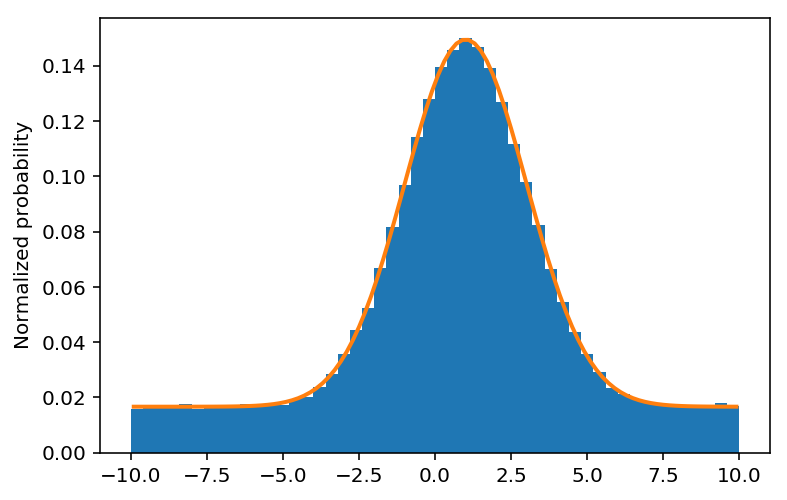

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(total_rand, bins=50, range=(-10,10), density=True)
ax.plot(xvals, pts, linewidth=2)
#ax.set_xlabel('xvar')
ax.set_ylabel('Normalized probability')
ax.set_ylim(ymin=0)
plt.show()